In [5]:
!pip install biopython
!pip install matplotlib
!pip install scikit-learn

Retrieved gene information for FTO
===== Patient P001 Nutrition Profile =====
BMI: 25.7 (Overweight)
Estimated daily calorie needs: 2108 calories

Macronutrient Recommendations:
- Protein: 62g (12% of calories)
- Carbs: 334g (63% of calories)
- Fat: 59g (25% of calories)
- Fiber: 17g

Key Micronutrient Focus Areas:
- Vitamin_d: 31
- Vitamin_b12: 3
- Folate: 600
- Calcium: 1800

Genetic Factors:
- MTHFR: 1 relevant SNPs
  * rs1801133 (CT): reduced_function
- VDR: 1 relevant SNPs
  * rs1544410 (AG): altered_function
- FTO: 1 relevant SNPs
  * rs9939609 (AT): increased_risk
- TCF7L2: 1 relevant SNPs
  * rs7903146 (CT): increased_risk

Top Food Recommendations:
1. Lentils
   Key nutrients: carbs, folate, protein, fiber
2. Almonds
   Key nutrients: carbs, protein, fiber
3. Spinach
   Key nutrients: carbs, folate, protein, fiber
4. Oatmeal
   Key nutrients: carbs, protein, fiber
5. Broccoli
   Key nutrients: carbs, folate, protein, fiber

Macronutrient distribution visualization saved.


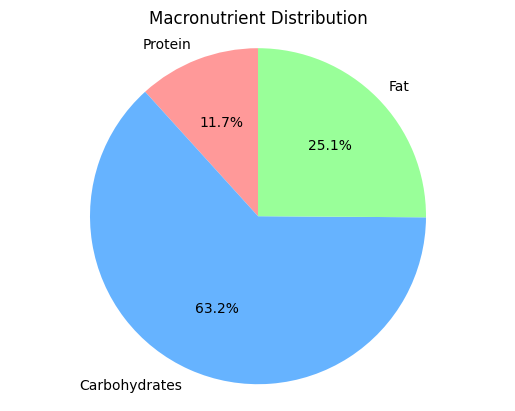

In [6]:
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio import Entrez
from Bio import SeqFeature
from Bio import pairwise2
from Bio.Seq import Seq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Always provide your email when using Entrez
Entrez.email = "your_email@example.com"

class GeneticNutrientAnalyzer:
    def __init__(self):
        # Gene-nutrient interaction database (simplified example)
        self.gene_nutrient_map = {
            'MTHFR': {'folate': 1.5, 'vitamin_b12': 1.3},
            'VDR': {'vitamin_d': 1.4, 'calcium': 1.2},
            'APOE': {'fat': 0.9, 'omega3': 1.5},
            'FADS1': {'omega3': 1.3, 'omega6': 0.8},
            'FTO': {'protein': 1.1, 'carbs': 0.9},
            'TCF7L2': {'carbs': 0.85, 'fiber': 1.2},
            'PPAR-gamma': {'fat': 0.9},
            'GSTM1': {'vitamin_c': 1.2, 'vitamin_e': 1.2, 'cruciferous': 1.3},
            'COMT': {'vitamin_b6': 1.2, 'magnesium': 1.2},
            'SOD2': {'manganese': 1.3, 'antioxidants': 1.2}
        }

        # SNP database (simplified)
        self.snp_effects = {
            'rs1801133': {'gene': 'MTHFR', 'effect': 'reduced_function'},
            'rs1544410': {'gene': 'VDR', 'effect': 'altered_function'},
            'rs429358': {'gene': 'APOE', 'effect': 'e4_allele'},
            'rs174537': {'gene': 'FADS1', 'effect': 'reduced_conversion'},
            'rs9939609': {'gene': 'FTO', 'effect': 'increased_risk'},
            'rs7903146': {'gene': 'TCF7L2', 'effect': 'increased_risk'},
            'rs1801282': {'gene': 'PPAR-gamma', 'effect': 'altered_function'},
            'rs1695': {'gene': 'GSTP1', 'effect': 'reduced_function'}
        }

    def fetch_gene_sequence(self, gene_id):
        """Fetch gene sequence using Biopython's Entrez"""
        try:
            # Search for gene
            search_handle = Entrez.esearch(db="gene", term=f"{gene_id}[Gene Name] AND homo sapiens[Organism]")
            search_record = Entrez.read(search_handle)
            search_handle.close()

            if not search_record["IdList"]:
                return None

            gene_id = search_record["IdList"][0]

            # Fetch gene details
            handle = Entrez.efetch(db="gene", id=gene_id, retmode="xml")
            record = Entrez.read(handle)
            handle.close()

            return record
        except Exception as e:
            print(f"Error fetching gene {gene_id}: {e}")
            return None

    def analyze_protein_properties(self, protein_sequence):
        """Analyze protein properties using Biopython's ProteinAnalysis"""
        try:
            # Convert string to Seq object
            seq = Seq(protein_sequence)
            # Create ProteinAnalysis object
            protein = ProteinAnalysis(str(seq))

            # Calculate various properties
            properties = {
                'molecular_weight': protein.molecular_weight(),
                'aromaticity': protein.aromaticity(),
                'instability_index': protein.instability_index(),
                'isoelectric_point': protein.isoelectric_point(),
                'secondary_structure_fraction': protein.secondary_structure_fraction()
            }

            return properties
        except Exception as e:
            print(f"Error analyzing protein: {e}")
            return None

    def analyze_snps(self, patient_snps):
        """Analyze SNPs and their nutritional implications"""
        nutrient_adjustments = {}
        affected_genes = set()

        for snp_id, genotype in patient_snps.items():
            if snp_id in self.snp_effects:
                gene = self.snp_effects[snp_id]['gene']
                affected_genes.add(gene)

                if gene in self.gene_nutrient_map:
                    for nutrient, factor in self.gene_nutrient_map[gene].items():
                        if nutrient not in nutrient_adjustments:
                            nutrient_adjustments[nutrient] = factor
                        else:
                            # If multiple SNPs affect the same nutrient, take the most significant effect
                            if abs(factor - 1) > abs(nutrient_adjustments[nutrient] - 1):
                                nutrient_adjustments[nutrient] = factor

        return nutrient_adjustments, affected_genes

    def calculate_homology(self, seq1, seq2):
        """Calculate sequence homology using Biopython's pairwise alignment"""
        alignments = pairwise2.align.globalxx(seq1, seq2)
        best_alignment = alignments[0]

        # Calculate percent identity
        matches = sum(a == b for a, b in zip(best_alignment.seqA, best_alignment.seqB))
        percent_identity = (matches / len(best_alignment.seqA)) * 100

        return percent_identity, best_alignment

class PatientData:
    def __init__(self, patient_id, age, gender, weight, height, activity_level,
                 health_conditions=None, genetic_data=None):
        self.patient_id = patient_id
        self.age = age
        self.gender = gender
        self.weight = weight  # kg
        self.height = height  # cm
        self.activity_level = activity_level
        self.health_conditions = health_conditions or []
        self.genetic_data = genetic_data or {}

        # Calculate BMI
        self.bmi = self.calculate_bmi()

        # Calculate BMR
        self.bmr = self.calculate_bmr()

    def calculate_bmi(self):
        """Calculate Body Mass Index"""
        return self.weight / ((self.height / 100) ** 2)

    def calculate_bmr(self):
        """Calculate Basal Metabolic Rate"""
        if self.gender == 'M':
            return 10 * self.weight + 6.25 * self.height - 5 * self.age + 5
        else:  # 'F'
            return 10 * self.weight + 6.25 * self.height - 5 * self.age - 161

    def add_genetic_data(self, snp_id, genotype):
        """Add genetic data (SNP information)"""
        self.genetic_data[snp_id] = genotype

    def add_genetic_data_from_file(self, filename):
        """Parse genetic data from common direct-to-consumer genetic testing files"""
        # This is a simplified example of parsing a 23andMe-like file
        try:
            with open(filename, 'r') as file:
                for line in file:
                    if line.startswith('#'):
                        continue
                    parts = line.strip().split()
                    if len(parts) >= 4:
                        rsid = parts[0]
                        genotype = parts[3]
                        self.genetic_data[rsid] = genotype
            print(f"Loaded {len(self.genetic_data)} genetic markers")
        except Exception as e:
            print(f"Error loading genetic data: {e}")

class NutrientRequirementPredictor:
    def __init__(self):
        self.genetic_analyzer = GeneticNutrientAnalyzer()

        # Base RDI values (simplified)
        self.base_rdi = {
            'protein': 0.8,  # g/kg body weight
            'carbs': 130,    # g/day
            'fat': 0.25,     # as fraction of total calories
            'fiber': 14,     # g per 1000 kcal
            'calcium': 1000, # mg
            'iron': 8,       # mg
            'vitamin_c': 75, # mg
            'vitamin_d': 15, # mcg
            'vitamin_b12': 2.4, # mcg
            'folate': 400,   # mcg
            'omega3': 1.1,   # g
            'omega6': 12,    # g
            'magnesium': 400, # mg
            'zinc': 11       # mg
        }

        # Activity level multipliers for TDEE
        self.activity_multipliers = {
            'sedentary': 1.2,
            'light': 1.375,
            'moderate': 1.55,
            'active': 1.725,
            'very active': 1.9
        }

        # Health condition adjustments
        self.condition_adjustments = {
            'diabetes': {'carbs': 0.8, 'fiber': 1.2},
            'hypertension': {'sodium': 0.6},
            'high_cholesterol': {'fat': 0.8, 'fiber': 1.2},
            'osteoporosis': {'calcium': 1.5, 'vitamin_d': 1.5},
            'anemia': {'iron': 1.8, 'vitamin_b12': 1.5, 'folate': 1.5},
            'celiac': {'iron': 1.3, 'calcium': 1.3, 'vitamin_d': 1.3}
        }

    def predict_requirements(self, patient):
        """Predict nutrient requirements based on patient data and genetic profile"""
        # Calculate base energy requirements
        tdee = patient.bmr * self.activity_multipliers.get(patient.activity_level.lower(), 1.2)

        # Initialize nutrient requirements with base values
        requirements = self.base_rdi.copy()

        # Adjust for body weight where applicable
        requirements['protein'] = patient.weight * requirements['protein']

        # Gender-specific adjustments
        if patient.gender == 'F':
            if patient.age < 50:  # Premenopausal
                requirements['iron'] = 18
            requirements['calcium'] = 1200 if patient.age > 50 else 1000

        # Age-specific adjustments
        if patient.age > 70:
            requirements['vitamin_d'] = 20
            requirements['protein'] = patient.weight * 1.0  # Higher protein for elderly

        # Health condition adjustments
        for condition in patient.health_conditions:
            if condition in self.condition_adjustments:
                for nutrient, factor in self.condition_adjustments[condition].items():
                    if nutrient in requirements:
                        requirements[nutrient] *= factor

        # Analyze genetic data using Biopython functions
        if patient.genetic_data:
            genetic_adjustments, affected_genes = self.genetic_analyzer.analyze_snps(patient.genetic_data)

            # Apply genetic adjustments
            for nutrient, factor in genetic_adjustments.items():
                if nutrient in requirements:
                    requirements[nutrient] *= factor

            # For demonstration purposes, fetch and analyze gene sequences for the first affected gene
            if affected_genes:
                gene = next(iter(affected_genes))
                gene_record = self.genetic_analyzer.fetch_gene_sequence(gene)
                if gene_record:
                    print(f"Retrieved gene information for {gene}")
                    # In a real application, you would analyze the gene sequence
                    # and potentially make further adjustments based on the analysis

        # Calculate macronutrient distribution
        protein_calories = requirements['protein'] * 4
        fat_calories = tdee * requirements['fat']
        fat_grams = fat_calories / 9
        carb_calories = tdee - protein_calories - fat_calories
        carb_grams = carb_calories / 4

        # Update macros in requirements
        requirements['calories'] = tdee
        requirements['carbs'] = carb_grams
        requirements['fat'] = fat_grams

        # Round all values
        for nutrient in requirements:
            requirements[nutrient] = round(requirements[nutrient])

        return requirements

    def generate_report(self, patient, requirements):
        """Generate a detailed nutrition report"""
        report = {
            'patient_id': patient.patient_id,
            'anthropometrics': {
                'age': patient.age,
                'gender': patient.gender,
                'weight': patient.weight,
                'height': patient.height,
                'bmi': round(patient.bmi, 1),
                'bmi_category': self.get_bmi_category(patient.bmi)
            },
            'energy_requirements': {
                'bmr': round(patient.bmr),
                'tdee': round(requirements['calories']),
                'activity_factor': self.activity_multipliers.get(patient.activity_level.lower(), 1.2)
            },
            'macronutrients': {
                'protein': {
                    'grams': requirements['protein'],
                    'calories': requirements['protein'] * 4,
                    'percent': round((requirements['protein'] * 4 / requirements['calories']) * 100)
                },
                'carbs': {
                    'grams': requirements['carbs'],
                    'calories': requirements['carbs'] * 4,
                    'percent': round((requirements['carbs'] * 4 / requirements['calories']) * 100)
                },
                'fat': {
                    'grams': requirements['fat'],
                    'calories': requirements['fat'] * 9,
                    'percent': round((requirements['fat'] * 9 / requirements['calories']) * 100)
                },
                'fiber': requirements.get('fiber', 0)
            },
            'micronutrients': {
                nutrient: requirements[nutrient] for nutrient in requirements
                if nutrient not in ['protein', 'carbs', 'fat', 'calories', 'fiber']
            },
            'genetic_factors': {
                'analyzed_snps': len(patient.genetic_data),
                'relevant_genes': self.identify_relevant_genes(patient.genetic_data)
            }
        }

        return report

    def get_bmi_category(self, bmi):
        """Get BMI category"""
        if bmi < 18.5:
            return "Underweight"
        elif bmi < 25:
            return "Normal weight"
        elif bmi < 30:
            return "Overweight"
        else:
            return "Obese"

    def identify_relevant_genes(self, genetic_data):
        """Identify nutrition-relevant genes from genetic data"""
        relevant_genes = {}

        for snp_id in genetic_data:
            if snp_id in self.genetic_analyzer.snp_effects:
                gene_info = self.genetic_analyzer.snp_effects[snp_id]
                gene = gene_info['gene']
                effect = gene_info['effect']

                if gene not in relevant_genes:
                    relevant_genes[gene] = []

                relevant_genes[gene].append({
                    'snp': snp_id,
                    'genotype': genetic_data[snp_id],
                    'effect': effect
                })

        return relevant_genes

    def visualize_requirements(self, requirements):
        """Create visualizations of nutritional requirements"""
        # Macronutrient pie chart
        protein_cals = requirements['protein'] * 4
        carb_cals = requirements['carbs'] * 4
        fat_cals = requirements['fat'] * 9

        labels = ['Protein', 'Carbohydrates', 'Fat']
        sizes = [protein_cals, carb_cals, fat_cals]
        colors = ['#ff9999','#66b3ff','#99ff99']

        fig1, ax1 = plt.subplots()
        ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax1.axis('equal')
        plt.title(f"Macronutrient Distribution")

        return fig1

class NutritionRecommender:
    def __init__(self, nutrient_predictor):
        self.predictor = nutrient_predictor

        # Simple food database with nutrition information (per 100g)
        self.food_database = {
            'chicken_breast': {'protein': 31, 'fat': 3.6, 'carbs': 0, 'fiber': 0, 'iron': 1.0, 'calories': 165},
            'salmon': {'protein': 22, 'fat': 13, 'carbs': 0, 'fiber': 0, 'omega3': 2.3, 'vitamin_d': 11, 'calories': 206},
            'brown_rice': {'protein': 5, 'fat': 1.8, 'carbs': 45, 'fiber': 3.5, 'magnesium': 44, 'calories': 216},
            'sweet_potato': {'protein': 2, 'fat': 0.1, 'carbs': 20, 'fiber': 3, 'vitamin_a': 709, 'calories': 86},
            'broccoli': {'protein': 2.8, 'fat': 0.4, 'carbs': 7, 'fiber': 2.6, 'vitamin_c': 89, 'folate': 63, 'calories': 34},
            'spinach': {'protein': 2.9, 'fat': 0.4, 'carbs': 3.6, 'fiber': 2.2, 'iron': 2.7, 'folate': 194, 'calories': 23},
            'almonds': {'protein': 21, 'fat': 49, 'carbs': 22, 'fiber': 12.5, 'vitamin_e': 25.6, 'magnesium': 270, 'calories': 579},
            'greek_yogurt': {'protein': 10, 'fat': 0.4, 'carbs': 3.6, 'calcium': 115, 'calories': 59},
            'eggs': {'protein': 12.6, 'fat': 10.6, 'carbs': 0.6, 'vitamin_d': 2.0, 'vitamin_b12': 1.1, 'calories': 143},
            'oatmeal': {'protein': 13, 'fat': 6.9, 'carbs': 68, 'fiber': 10.6, 'magnesium': 177, 'calories': 389},
            'lentils': {'protein': 9, 'fat': 0.4, 'carbs': 20, 'fiber': 7.9, 'iron': 3.3, 'folate': 181, 'calories': 116},
            'quinoa': {'protein': 4.4, 'fat': 1.9, 'carbs': 21.3, 'fiber': 2.8, 'magnesium': 64, 'iron': 1.5, 'calories': 120},
        }

    def recommend_foods(self, requirements, n_recommendations=5):
        """Recommend foods based on nutritional requirements"""
        # Find nutrients that need focus
        focus_nutrients = []

        # Special nutrient focus based on genetic data
        if 'genetic_factors' in requirements and 'relevant_genes' in requirements['genetic_factors']:
            for gene, snps in requirements['genetic_factors']['relevant_genes'].items():
                if gene in self.predictor.genetic_analyzer.gene_nutrient_map:
                    for nutrient in self.predictor.genetic_analyzer.gene_nutrient_map[gene]:
                        if nutrient not in focus_nutrients:
                            focus_nutrients.append(nutrient)

        # Add focus on micronutrients based on health conditions
        for condition in requirements.get('health_conditions', []):
            if condition == 'anemia':
                focus_nutrients.extend(['iron', 'vitamin_b12', 'folate'])
            elif condition == 'osteoporosis':
                focus_nutrients.extend(['calcium', 'vitamin_d'])
            elif condition == 'high_cholesterol':
                focus_nutrients.extend(['fiber', 'omega3'])

        # Make unique list
        focus_nutrients = list(set(focus_nutrients))

        # Score foods based on nutritional profile and focus nutrients
        food_scores = {}
        for food, nutrients in self.food_database.items():
            score = 0

            # Base score on protein quality
            if 'protein' in nutrients and nutrients['protein'] > 0:
                score += nutrients['protein'] / nutrients['calories'] * 100

            # Add points for fiber
            if 'fiber' in nutrients and nutrients['fiber'] > 0:
                score += nutrients['fiber'] * 2

            # Add points for focus nutrients
            for nutrient in focus_nutrients:
                if nutrient in nutrients and nutrients[nutrient] > 0:
                    score += 10

            food_scores[food] = score

        # Sort foods by score
        sorted_foods = sorted(food_scores.items(), key=lambda x: x[1], reverse=True)

        # Return top recommendations
        top_foods = sorted_foods[:n_recommendations]
        recommendations = []

        for food, score in top_foods:
            nutrients = self.food_database[food]
            recommendations.append({
                'food': food,
                'score': score,
                'key_nutrients': [n for n in focus_nutrients if n in nutrients and nutrients[n] > 0],
                'nutrition': nutrients
            })

        return recommendations, focus_nutrients

# Example of using these classes for personalized nutrition
if __name__ == "__main__":
    # Sample genetic data (simplified for demonstration)
    sample_genetic_data = {
        'rs1801133': 'CT',  # MTHFR
        'rs1544410': 'AG',  # VDR
        'rs9939609': 'AT',  # FTO
        'rs7903146': 'CT'   # TCF7L2
    }

    # Create patient profile
    patient = PatientData(
        patient_id="P001",
        age=42,
        gender="F",
        weight=70,
        height=165,
        activity_level="moderate",
        health_conditions=["osteoporosis"],
        genetic_data=sample_genetic_data
    )

    # Option to load genetic data from file
    # patient.add_genetic_data_from_file("patient_genetics.txt")

    # Create nutrient predictor
    predictor = NutrientRequirementPredictor()

    # Predict requirements
    requirements = predictor.predict_requirements(patient)

    # Generate report
    report = predictor.generate_report(patient, requirements)

    # Create nutrition recommender
    recommender = NutritionRecommender(predictor)

    # Get food recommendations
    recommendations, focus_nutrients = recommender.recommend_foods(report)

    # Display results
    print(f"===== Patient {patient.patient_id} Nutrition Profile =====")
    print(f"BMI: {patient.bmi:.1f} ({report['anthropometrics']['bmi_category']})")
    print(f"Estimated daily calorie needs: {report['energy_requirements']['tdee']} calories")

    print("\nMacronutrient Recommendations:")
    for macro, data in report['macronutrients'].items():
        if isinstance(data, dict):
            print(f"- {macro.capitalize()}: {data['grams']}g ({data['percent']}% of calories)")
        else:
            print(f"- {macro.capitalize()}: {data}g")

    print("\nKey Micronutrient Focus Areas:")
    for nutrient in focus_nutrients:
        if nutrient in report['micronutrients']:
            print(f"- {nutrient.capitalize()}: {report['micronutrients'][nutrient]}")

    print("\nGenetic Factors:")
    genes = report['genetic_factors']['relevant_genes']
    for gene, snps in genes.items():
        print(f"- {gene}: {len(snps)} relevant SNPs")
        for snp in snps:
            print(f"  * {snp['snp']} ({snp['genotype']}): {snp['effect']}")

    print("\nTop Food Recommendations:")
    for i, rec in enumerate(recommendations):
        print(f"{i+1}. {rec['food'].replace('_', ' ').title()}")
        print(f"   Key nutrients: {', '.join(rec['key_nutrients'])}")

    # Create visualization
    fig = predictor.visualize_requirements(requirements)
    plt.savefig(f"patient_{patient.patient_id}_macro_distribution.png")
    print("\nMacronutrient distribution visualization saved.")